### Naïve Inception module from scratch

In [5]:
# 인셉션 모듈을 만드는 데에 필요한 모듈 불러오기
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model # 모델 시각화

In [6]:
# Naïve Inception 블록을 만들기 위한 함수
def naive_inception(input_layer, conv1_filter, conv3_filter, conv5_filter):

    conv1 = keras.layers.Conv2D(conv1_filter, (1, 1), padding='same', activation='relu')(input_layer)
    conv3 = keras.layers.Conv2D(conv3_filter, (3, 3), padding='same', activation='relu')(input_layer)
    conv5 = keras.layers.Conv2D(conv5_filter, (5, 5), padding='same', activation='relu')(input_layer)
    pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)

    out_layer = keras.layers.Concatenate()([conv1, conv3, conv5, pool])
    return out_layer

In [7]:
input_data = keras.layers.Input(shape=(256, 256, 3))
naive_inception_out = naive_inception(input_data, 64, 128, 32)

In [8]:
print(naive_inception_out)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 227), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [9]:
# 모델 만들기
model = keras.models.Model(inputs=input_data, outputs=naive_inception_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 2432        input_1[0][0]                    
______________________________________________________________________________________________

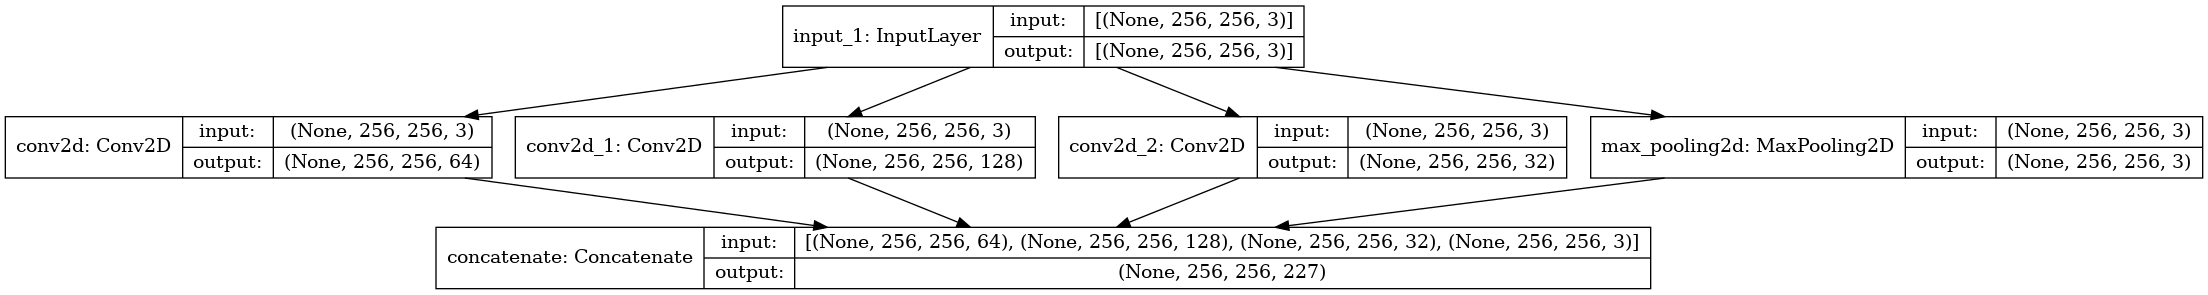

In [10]:
plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

### Inception module with 1x1 convolution

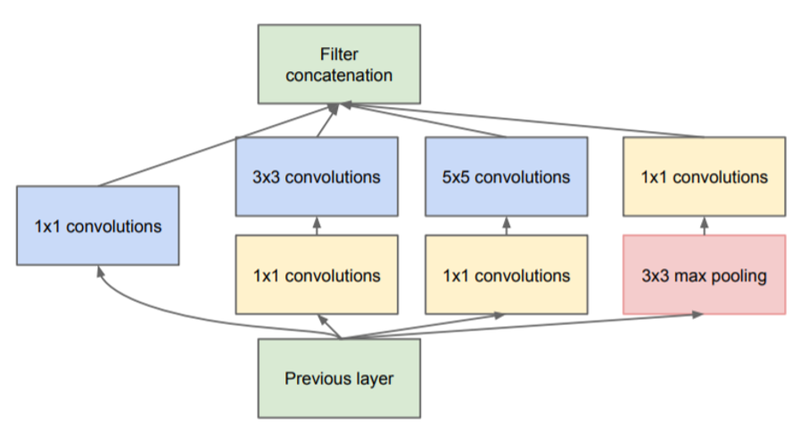

In [11]:
def inception(input_layer, conv1_filter, conv3_in, conv3_out, conv5_in, conv5_out, pooling_out):
    conv1 = keras.layers.Conv2D(conv1_filter, (1,1), padding='same', activation='relu')(input_layer)

    conv3 = keras.layers.Conv2D(conv3_in, (1,1), padding='same', activation='relu')(input_layer) # Naive 버전과 가장 차별화되는 부분: 1x1 convolution
    conv3 = keras.layers.Conv2D(conv3_out, (3,3), padding='same', activation='relu')(conv3)
    
    conv5 = keras.layers.Conv2D(conv5_in, (1, 1), padding='same', activation='relu')(input_layer)
    conv5 = keras.layers.Conv2D(conv5_out, (5, 5), padding='same', activation='relu')(conv5)
    
    pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
    pool = keras.layers.Conv2D(pooling_out, (1,1), padding='same', activation='relu')(pool)

    out_layer = keras.layers.Concatenate()([conv1, conv3, conv5, pool])
    return out_layer

In [12]:
input_data = keras.layers.Input(shape=(256, 256, 3))
inception_out = inception(input_data, 64, 96, 128, 16, 32, 32)
print(inception)

<function inception at 0x7fa6584708b0>


In [13]:
model = keras.models.Model(inputs=input_data, outputs=inception_out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 256, 256, 96) 384         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 16) 64          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 3)  0           input_2[0][0]                    
____________________________________________________________________________________________

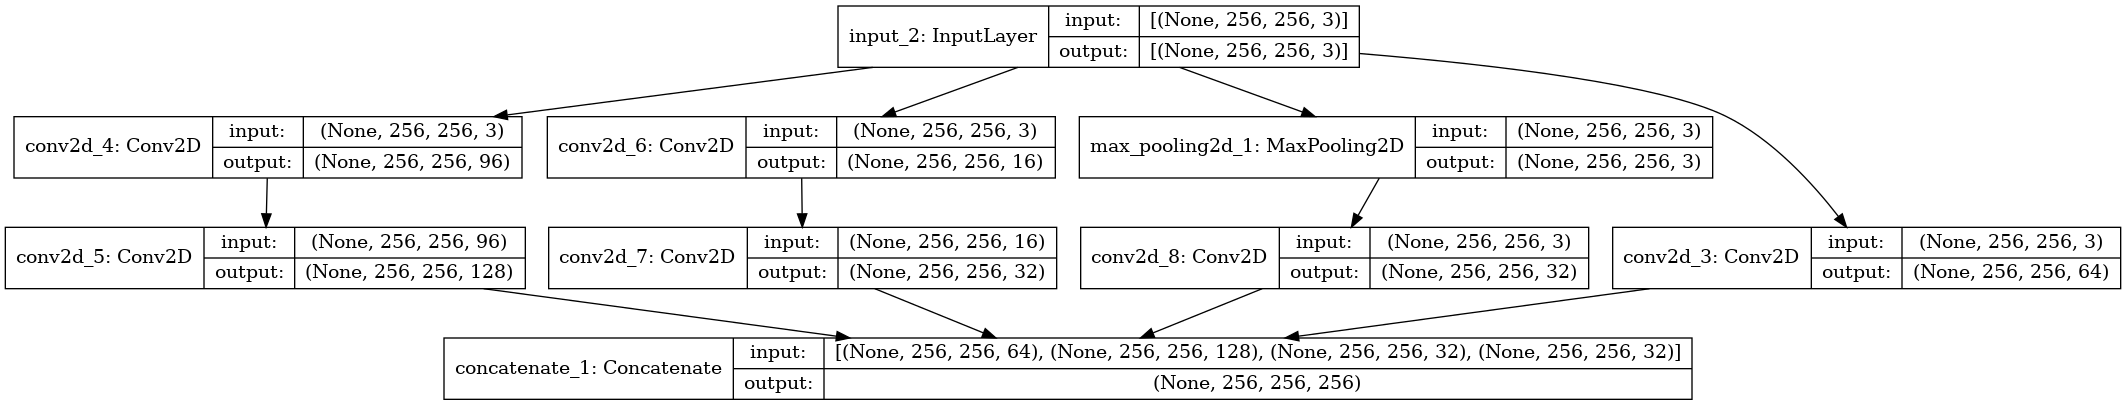

In [14]:
plot_model(model, show_shapes=True, to_file='inception.png')

### Skip Connection (Resnet)

In [15]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model

In [16]:
def residual_module(input_layer, n_filters):  
	merge_input = input_layer

# if문에서는 채널 사이즈가 동일한지 확인하고, 만일 동일하지 않다면 1x1 convolution을 통해서 채널 사이즈를 맞춰 준다.
	if input_layer.shape[-1] != n_filters:
		merge_input = keras.layers.Conv2D(n_filters, (1,1), padding='same', activation='relu')(input_layer) # n_filter로 채널 사이즈를 맞춰 준다.
	# Conv2D layer
	conv1 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(input_layer)
	# Conv2D layer
	conv2 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='linear')(conv1)
	
  # Add를 통해서 skip connection을 구현하는 부분
	out_layer = keras.layers.Add()([conv2, merge_input])
	out_layer = keras.layers.Activation('relu')(out_layer)
 
	return out_layer

In [17]:
input = keras.layers.Input(shape=(256, 256, 3))
residual_out = residual_module(input, 64)

In [18]:
print(residual_out)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 64), dtype=tf.float32, name=None), name='activation/Relu:0', description="created by layer 'activation'")


In [19]:
model = keras.models.Model(inputs=input, outputs=residual_out)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 256, 256, 64) 256         input_3[0][0]                    
____________________________________________________________________________________________

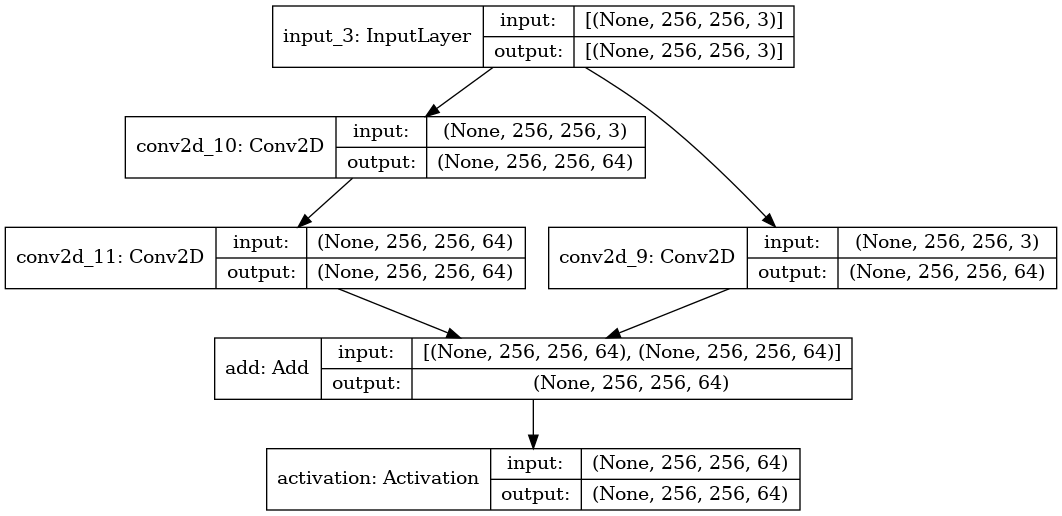

In [20]:
plot_model(model, show_shapes=True, to_file='residual_module.png')